In [1]:
import numpy as np
import glob
import cv2
import blobfile as bf
import PIL
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
seed_everything(47)

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def plot_sample(img, highlight=None, **kwargs):
    columns = 6
    rows = 17
    fig = plt.figure(figsize=(20, 20), dpi=100)
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = img[i]
        
        if highlight is not None:
            top, bottom, left, right = [10]*4

            if i == highlight['base_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 255, 0))
            elif i == highlight['src_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 255))
            elif i == highlight['dst_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 0, 0))
            
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = kwargs[k][i].astype(np.uint8)
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()
    return fig



Global seed set to 47


# How much background affect the lighting estimation from DECA?

In [2]:
# Load images of foreground/background/original

fgr_file = _list_image_files_recursively('./fgr/')
bgr_file = _list_image_files_recursively('./bgr/')
org_file = _list_image_files_recursively('./org/')
print(len(fgr_file), len(bgr_file), len(org_file))


file_dict = {}
for path in org_file:
    name = path.split('/')[-1]
    file_dict[name] = {'org':None, 'fgr':None}
    file_dict[name]['org'] = path
    file_dict[name]['fgr'] = [p for p in fgr_file if name.split('.')[0] in p][0]
    assert file_dict[name]['fgr'] != None
    assert file_dict[name]['org'] != None

# Check all images have paired.
tmp = copy.deepcopy(fgr_file)
for i in list(file_dict.keys()):
    i = i.split('.')[0]
    for idx, j in enumerate(tmp):
        if i in j:
            del(tmp[idx])
assert tmp == []


32 19 32


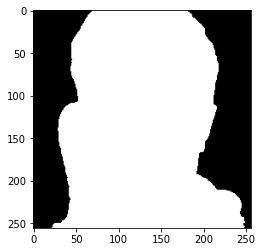

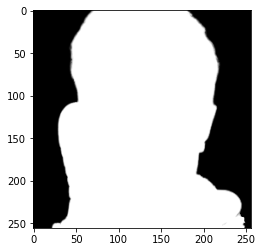

In [3]:
image_dict = copy.deepcopy(file_dict)
for name, v in file_dict.items():
    for k in ['org', 'fgr']:
        with bf.BlobFile(v[k], "rb") as f:
            pil_image = PIL.Image.open(f)
            pil_image.load()
            pil_image = pil_image.convert("RGBA")
        image_dict[name][k] = np.array(pil_image).astype(np.uint8)
    image_dict[name]['mask'] = image_dict[name]['fgr'] != 0
    # image_dict[name]['mask'] = 1 - np.isclose(image_dict[name]['fgr'], [0])
    # image_dict[name]['mask'] = image_dict[name]['mask'][..., [0]] * image_dict[name]['mask'][..., [1]] * image_dict[name]['mask'][..., [2]]

im = image_dict['60065.jpg']
plt.imshow(im['fgr'][..., [3]] > 127.5, cmap='gray')
plt.show()

plt.imshow(im['fgr'][..., [3]], cmap='gray')
plt.show()

bgr_dict = {}
for path in bgr_file:
    name = path.split('/')[-1]
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
        pil_image = pil_image.convert("RGBA")
    bgr_dict[name] = np.array(pil_image)

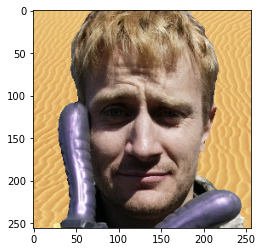

In [4]:
# Overlay the image
def overlay_image(fgr, bgr, mask):
    '''
    Overlay the image
    :param fgr: foreground image
    :param bgr: background image
    :param mask: mask image
    [#] All images need to be the same shape (H, W, 3)
    '''
    return (fgr * mask) + bgr * (1 - mask)

def random_crop(img, image_size=256):
    import random
    crop_y = random.randrange(img.shape[0] - image_size + 1)
    crop_x = random.randrange(img.shape[1] - image_size + 1)
    return img[crop_y : crop_y + image_size, crop_x : crop_x + image_size]

img_name = '60065.jpg'
bgr_name = [name for name in bgr_dict.keys() if 'sahara' in name][0]

ovl_im = overlay_image(fgr=image_dict[img_name]['fgr'][..., [0, 1, 2]], 
                    bgr=random_crop(bgr_dict[bgr_name][..., [0, 1, 2]]),
                    mask=image_dict[img_name]['fgr'][..., [3]] > 127.5)
plt.imshow(ovl_im)
plt.show()


Global seed set to 47


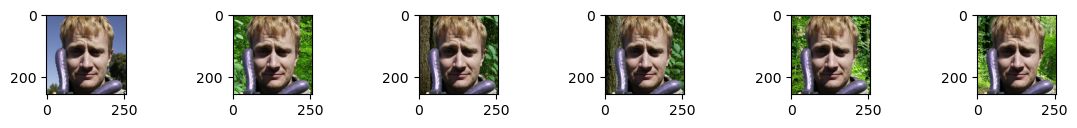

In [5]:
# Create Overlay samples
img_name = '60065.jpg'
bgr_name = [name for name in bgr_dict.keys() if 'forest' in name][0]

ovl_dict = {img_name:{}}
seed_everything(47)
for i in range(5):
    if i == 0:
        ovl_dict[img_name][bgr_name] = [image_dict[img_name]['org'][..., [0, 1, 2]]]
    
    ovl_img = overlay_image(fgr=image_dict[img_name]['fgr'][..., [0, 1, 2]], 
                        bgr=random_crop(bgr_dict[bgr_name][..., [0, 1, 2]]),
                        mask=image_dict[img_name]['fgr'][..., [3]] > 127.5)
    ovl_dict[img_name][bgr_name].append(ovl_img)

fig = plot_sample(img=np.stack(ovl_dict[img_name][bgr_name], axis=0))

In [6]:
# Test on DECA

from skimage.io import imread, imsave
x = imread('./bgr/plain/black.png')
import sys
def get_deca(data, dat_type, cfg=None):
    # In-the-wild
    sys.path.append('../../../cond_utils/')
    sys.path.append('../../../cond_utils/deca/')
    from deca import get_deca_emb

    itw_path = "../../itw_images/aligned/"
    device = 'cuda:0'

    # DECA
    deca_itw = get_deca_emb.get_deca_emb(data=data, dat_type=dat_type, device=device)

    params_itw = {}
    for img_name in deca_itw.keys():
        params_itw[img_name] = deca_itw[img_name]
        
    params_set = params_itw
    return params_set

data = {
    'image' : np.stack(ovl_dict[img_name][bgr_name], axis=0),
    'imagename' : [f'ovl{i}_{img_name}' for i in range(len(ovl_dict[img_name][bgr_name]))]
    }
print(data['imagename'])
out = get_deca(data=data, dat_type='img')

['ovl0_60065.jpg', 'ovl1_60065.jpg', 'ovl2_60065.jpg', 'ovl3_60065.jpg', 'ovl4_60065.jpg', 'ovl5_60065.jpg']
total 6 images
creating the FLAME Decoder
trained model found. load /home/mint/mothership/sample_scripts/cond_utils/deca/data/deca_model.tar


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


In [7]:
print(out.keys())

dict_keys(['ovl0_60065.jpg', 'ovl1_60065.jpg', 'ovl2_60065.jpg', 'ovl3_60065.jpg', 'ovl4_60065.jpg', 'ovl5_60065.jpg'])


In [9]:
print(out['ovl0_60065.jpg']['light'])
print(out['ovl1_60065.jpg']['light'])

[ 3.4063814   3.4182117   3.4240203   0.2447223   0.2731144   0.27873707
  0.36326286  0.37438118  0.37373984 -0.53145957 -0.511477   -0.49685538
 -0.02802198 -0.02605348 -0.0254976   0.15530688  0.17207308  0.17424926
  0.5655835   0.57417613  0.5728966   0.25129333  0.25584137  0.25848323
  0.7325827   0.7334002   0.73769367]
